In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from random import shuffle
from PIL import Image
import torchvision
import pandas as pd
import numpy as np

In [ ]:
import h5py
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch.nn.functional as F

In [ ]:
from torch.utils.data import random_split, DataLoader

Use the following code if using colab, change to local path if using local data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Deep_learning_Data/ACDC_preprocessed.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Deep_learning_Data/ACDC_preprocessed.rar

Creating    ACDC_preprocessed                                         OK
Creating    ACDC_preprocessed/ACDC_testing_volumes                    OK
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient101_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient101_frame14.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient102_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient102_frame13.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient103_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient103_frame11.h5       1%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient104_frame01.h5       1%  OK 
Extracting  ACDC_preproce

Setting a random seed for reproducibility

In [ ]:
# ensure the experiment produces same result on each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [ ]:
train_folder_path = "/content/ACDC_preprocessed/ACDC_training_volumes"
test_folder_path = "/content/ACDC_preprocessed/ACDC_testing_volumes"
batch_size = 4

# Dataset class
This class creates the datasets from the corresponding folders that will later be used to creat the dataloaders

We define the set of transformations that can be applied on our images and their correspondng masks, provided as an argument to the dataset class.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline using albumentations
augmentation = A.Compose([
    A.HorizontalFlip(p=0.3),  # Random horizontal flip with 50% probability
    A.Rotate(limit=10, p=0.3),  # Random rotation between -30 and 30 degrees
    A.RandomBrightnessContrast(p=0.2),  # Random brightness and contrast adjustment
    ToTensorV2(),  # Convert to PyTorch tensor
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class H5FolderDataset(Dataset):
    def __init__(self, folder_path, target_size=(256, 232), mode='train', transform=None):
        super().__init__()
        """
        Initialize the dataset with the path to the folder containing H5 files.
        Args:
            folder_path (str): Path to the folder containing H5 files.
            target_size (tuple): Desired size (height, width) for all images and masks.
        """
        self.folder_path = folder_path
        self.target_size = target_size
        self.mode = mode
        self.transform = transform  # Add transform argument

        # Collect all .h5 file paths in the folder
        self.h5_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.h5')]
        if not self.h5_files:
            raise ValueError(f"No .h5 files found in folder: {folder_path}")

        # Create a list of (file_path, index) pairs for each sample
        self.samples = []
        for h5_file in self.h5_files:
            with h5py.File(h5_file, 'r') as h5:
                num_samples = len(h5['image'])  # Assuming all H5 files have 'image' dataset
                self.samples.extend([(h5_file, idx) for idx in range(num_samples)])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, local_idx = self.samples[idx]

        # Open the specific H5 file and read the data
        with h5py.File(file_path, 'r') as h5:
            image = h5['image'][local_idx]
            mask = h5['label'][local_idx]

        # Convert to tensor (add channel dimension)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension for image
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Adding channel dimension for mask

        # Resize to target size
        image = torch.nn.functional.interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear').squeeze(0)
        mask = torch.nn.functional.interpolate(mask.unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze(0).long()

        # Convert to NumPy arrays for Albumentations
        image_np = image.squeeze(0).cpu().numpy()  # Convert image to (H, W) NumPy array
        mask_np = mask.squeeze(0).cpu().numpy()    # Convert mask to (H, W) NumPy array


        # Apply augmentations if transform is provided
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented['image']
            mask = augmented['mask']

       # Ensure mask is converted to long type after transformations
        image = torch.tensor(image, dtype=torch.float32)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long for CrossEntropyLoss


        return image, mask

In [ ]:
# Create the full dataset
full_train_dataset = H5FolderDataset(folder_path=train_folder_path, mode='train', transform=augmentation)

# Define the sizes for train and validation splits
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 4  # Adjust as needed
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Visualizing samples from our dataset

<ipython-input-21-25ac323d469c>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Add channel dimension
<ipython-input-21-25ac323d469c>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long for CrossEntropyLoss


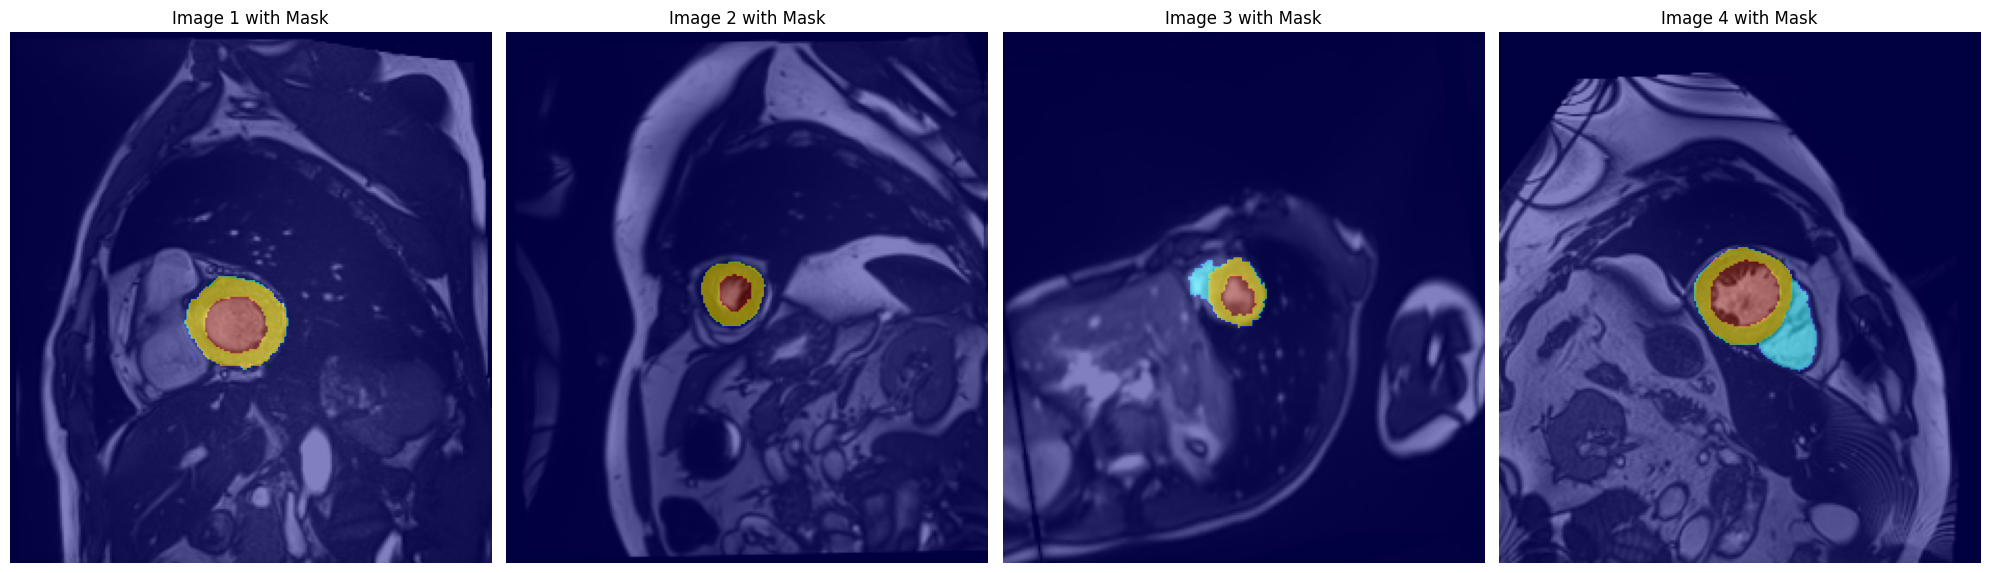

In [ ]:
# Load a batch from your data loader
images, masks = next(iter(train_data_loader))  # Assuming 'images' is [B, C, H, W] and 'masks' is [B, H, W]

# Create subplots to visualize images with overlaid masks
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

for i in range(4):
    ax = axes[i]

    # Display the image (grayscale)
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')

    # Overlay the mask (with transparency)
    ax.imshow(masks[i].squeeze().numpy(), cmap='jet', alpha=0.5)  # alpha controls transparency (0.0 to 1.0)

    ax.axis('off')
    ax.set_title(f"Image {i + 1} with Mask")

plt.tight_layout()
plt.show()

# Model defining
U-Net model is used

This function is to edit output and input of decoding and encoding layers to be compatible

In [ ]:
def crop_and_concat(enc_features, dec_features):
    _, _, h, w = dec_features.size()
    enc_h, enc_w = enc_features.size(2), enc_features.size(3)
    crop_h = (enc_h - h) // 2
    crop_w = (enc_w - w) // 2
    enc_features_cropped = enc_features[:, :, crop_h:crop_h + h, crop_w:crop_w + w]
    return torch.cat((enc_features_cropped, dec_features), dim=1)

In [ ]:
class U_Net(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):

        super(U_Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.up5 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )

        self.up_conv5 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )

        self.up_conv4 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )

        self.up_conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )

        self.up_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
        )

        self.final = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64, out_channels, 1)
        )

    def forward(self, x):

        # encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        # Decoding + Concat path
        d5 = self.up5(x5)
        d5 = crop_and_concat(x4, d5)
        d5 = self.up_conv5(d5)

        d4 = self.up4(d5)
        d4 = crop_and_concat(x3, d4)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        d3 = crop_and_concat(x2, d3)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        d2 = crop_and_concat(x1, d2)
        d2 = self.up_conv2(d2)

        d1 = self.final(d2)
        return d1

Visualize the network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U_Net()
model.to(device)

U_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )

Adam Optimizer is used

In [ ]:
# optimizer to be used
optimizer = torch.optim.Adam(model.parameters(), 0.001, [0.5, 0.999])

### Dice_score function defined to calculate dice score per category for each trained model over the test dataset

In [ ]:
import torch
import torch.nn.functional as F

def dice_score(pred, target, num_classes, eps=1e-6):
    """
    Compute the Dice score for multi-class segmentation.

    Args:
        pred (torch.Tensor): Predicted labels of shape [batch_size, H, W].
        target (torch.Tensor): Ground truth labels of shape [batch_size, H, W].
        num_classes (int): Number of segmentation classes.
        eps (float): Small value to avoid division by zero.

    Returns:
        torch.Tensor: Dice score for each class as a tensor of shape [num_classes].
    """
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()  # Binary mask for predicted class c
        target_c = (target == c).float()  # Binary mask for ground truth class c

        intersection = (pred_c * target_c).sum(dim=(1, 2))  # Per-sample intersection
        union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Per-sample union

        dice = (2.0 * intersection + eps) / (union + eps)  # Per-sample Dice coefficient
        dice_scores.append(dice.mean().item())  # Average Dice for this class across batch

    return torch.tensor(dice_scores)  # Return Dice scores for all classes

## Visualization function defined for visualizing actual VS predicted masks

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Assuming you have a test dataloader (`test_data_loader`), criterion, and device (CPU/GPU)
# and the model is already loaded and in evaluation mode.

def visualize_result(model, test_data_loader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during inference
        for step, (images, labels) in enumerate(test_data_loader):
            images, labels = images.to(device), labels.to(device).squeeze(1)

            # Forward pass
            outputs = model(images)
            outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # Get the predicted mask (argmax to get the class with highest probability)
            preds = torch.argmax(outputs_resized, dim=1)

            # Convert tensors to numpy arrays for plotting
            image = images[0].cpu().numpy()  # MRI image (typically 2D or 3D)
            actual_mask = labels[0].cpu().numpy()  # Actual ground truth mask
            predicted_mask = preds[0].cpu().numpy()  # Predicted mask

            # Plotting the results
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Plot the original MRI image
            axs[0].imshow(image[0], cmap='gray')  # Assuming a single channel MRI image
            axs[0].set_title("MRI Image")
            axs[0].axis('off')  # Hide axes

            # Plot the actual mask
            axs[1].imshow(actual_mask, cmap='jet')
            axs[1].set_title("Actual Mask")
            axs[1].axis('off')

            # Plot the predicted mask
            axs[2].imshow(predicted_mask, cmap='jet')
            axs[2].set_title("Predicted Mask")
            axs[2].axis('off')

            plt.show()
            break  # Show just one example for simplicity, remove if you want to visualize more

## Model 1:
- Using Cross entropy loss with equal weights for all categories.
- No data augmentation/transformation applied on dataset used

In [ ]:
# Create the full dataset
full_train_dataset = H5FolderDataset(folder_path=train_folder_path, mode='train') #No transformation

# Define the sizes for train and validation splits
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 4
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Categorical Cross Entropy used as the loss function

In [ ]:
# define loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
C_CONF='expandable_segments:True'

In [ ]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

save_path = "checkpoint_no_w_transf.pth"

# Training loop
for epoch in range(0, 20):
    # train
    print("epoch: ",epoch+1)
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(train_data_loader):

        # Move images and labels to device
        #batch_size = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        # Remove extra dimension from labels (if necessary)
        labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

        # Forward pass (no softmax here)
        optimizer.zero_grad()
        outputs = model(images)  # Raw logits

        # Resize the output to match the target dimensions (labels)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss (no softmax on outputs)
        loss = criterion(outputs_resized, labels)  # Directly use raw logits
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Accuracy calculation (pixel-wise)
        for j in range(outputs_resized.shape[0]):
            output = outputs_resized[j]  # Resized predicted output for a single image
            gt = labels[j]  # Ground truth for the same image

            output = torch.argmax(output, dim=0)  # Predicted class for each pixel
            gt = gt.squeeze(0)  # Ensure ground truth is 2D

            # Exclude background (class 0) from accuracy calculation
            #mask = gt != 0

            correct += float(torch.sum(output == gt))  # Correct predictions
            total += float(gt.numel()) # Total number of pixels in the image

    # Update training loss and accuracy
    train_loss = train_loss / len(train_data_loader)
    train_accuracy = correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Save model checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, save_path)

    # Validation loop (same as training loop but with no gradient updates)
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(val_data_loader):  # Change to validation data loader
        with torch.no_grad():
            batch_size = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            # Remove extra dimension from labels (if necessary)
            labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

            # Forward pass
            outputs = model(images)  # Raw logits

            # Resize the output to match the target dimensions (labels)
            outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # Compute loss
            loss = criterion(outputs_resized, labels)
            val_loss += loss.item()

            # Accuracy calculation (pixel-wise)
            for j in range(outputs_resized.shape[0]):
              output = outputs_resized[j]  # Resized predicted output for a single image
              gt = labels[j]  # Ground truth for the same image
              output = torch.argmax(output, dim=0)  # Predicted class for each pixel
              gt = gt.squeeze(0)  # Ensure ground truth is 2D

              # Exclude background (class 0) from accuracy calculation
              #mask = gt != 0

              correct += float(torch.sum(output == gt))  # Correct predictions where gt != 0
              total += float(gt.numel()) # Total number of pixels in the image

    # Update validation loss and accuracy
    val_loss = val_loss / len(val_data_loader)
    val_accuracy = correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{10}")
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f} | Validation Accuracy: {val_accuracy:.4f}")

epoch:  1
Epoch 1/10
Training Loss: 0.1030 | Validation Loss: 0.1442
Training Accuracy: 0.9698 | Validation Accuracy: 0.9531
epoch:  2
Epoch 2/10
Training Loss: 0.0408 | Validation Loss: 0.0755
Training Accuracy: 0.9845 | Validation Accuracy: 0.9761
epoch:  3
Epoch 3/10
Training Loss: 0.0298 | Validation Loss: 0.0471
Training Accuracy: 0.9885 | Validation Accuracy: 0.9850
epoch:  4
Epoch 4/10
Training Loss: 0.0250 | Validation Loss: 0.0522
Training Accuracy: 0.9904 | Validation Accuracy: 0.9856
epoch:  5
Epoch 5/10
Training Loss: 0.0222 | Validation Loss: 0.0874
Training Accuracy: 0.9915 | Validation Accuracy: 0.9796
epoch:  6
Epoch 6/10
Training Loss: 0.0194 | Validation Loss: 0.0524
Training Accuracy: 0.9924 | Validation Accuracy: 0.9851
epoch:  7
Epoch 7/10
Training Loss: 0.0198 | Validation Loss: 0.0295
Training Accuracy: 0.9924 | Validation Accuracy: 0.9897
epoch:  8
Epoch 8/10
Training Loss: 0.0173 | Validation Loss: 0.0277
Training Accuracy: 0.9931 | Validation Accuracy: 0.9908


Training accuracy starts at a very high value of 96% from the first epoch, which is suspicious

In [ ]:
# Save the model's state_dict
save_train = "trained_model_no_w_transf.pth"
torch.save(model.state_dict(), save_train)
print(f"Model saved to {save_train}")

Model saved to trained_model_no_w_transf.pth


**Run the saved model on test dataset**

**test accuracy:** 98% (despite the visualization figure showing a bad mask predicition)

**Dice scores per category:**

- Class 0 Dice Score: 0.9905
- Class 1 Dice Score: 0.5690
- Class 2 Dice Score: 0.6835
- Class 3 Dice Score: 0.8389

average dice score = 7704

average dice score excluding class 0 = 6970

**Run saved model on test dataset**

In [ ]:
##Create test dataloader
test_dataset = H5FolderDataset(folder_path=test_folder_path, mode='train')
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

In [ ]:
import torch
import torch.nn.functional as F
import os

# Define the save path for the checkpoint
save_path = "checkpoint_no_w_transf.pth"

# Step 1: Load the saved model checkpoint
if os.path.exists(save_path):
    checkpoint = torch.load(save_path)

    # Initialize the model (use the same architecture as during training)
    model = model  # Make sure this matches the model used during training

    # Load the model state_dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Step 2: Switch the model to evaluation mode
    model.eval()  # This is important for inference

    # Optionally, load the optimizer state if you need to continue training
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

else:
    print("Checkpoint not found. Please train the model first.")
    exit()


# Step 3: Test the model on the test dataset
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():  # No need to compute gradients during testing
    for step, (images, labels) in enumerate(test_data_loader):
        images, labels = images.to(device), labels.to(device).squeeze(1)

        # Forward pass
        outputs = model(images)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss
        loss = criterion(outputs_resized, labels)
        test_loss += loss.item()

        # Pixel-wise accuracy
        preds = torch.argmax(outputs_resized, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.numel()

test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


<ipython-input-54-3dbeefb3762c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


Test Loss: 3.7101, Test Accuracy: 0.9850


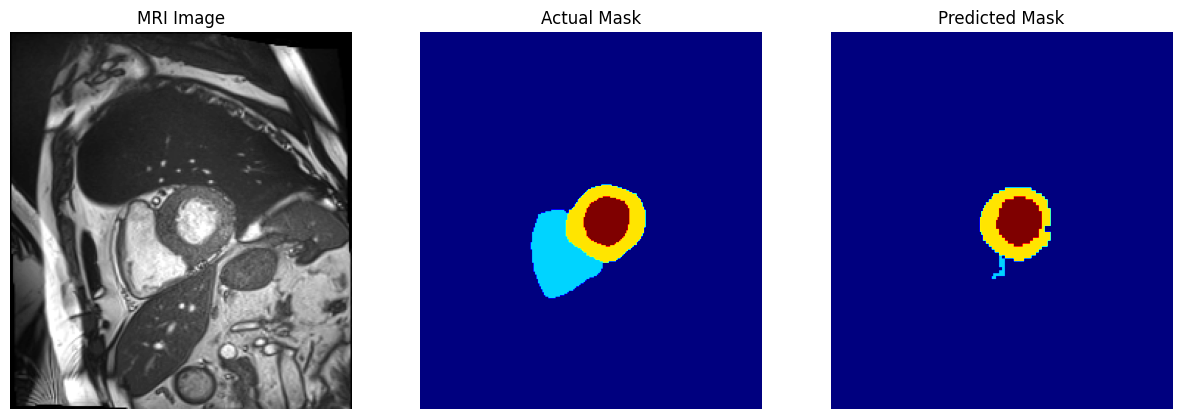

In [ ]:
visualize_result(model, test_data_loader, device)

#### Dice score per category

In [ ]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_data_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Convert logits to predicted class labels
        preds = torch.argmax(outputs, dim=1)  # Shape: [batch_size, H, W]

        # Resize predictions to match ground truth
        if preds.shape[1:] != masks.shape[1:]:
            masks = masks.squeeze(1)
            preds = F.interpolate(
                preds.unsqueeze(1).float(),  # Add channel dimension
                size=masks.shape[1:],        # Match masks' spatial dimensions
                mode='nearest'               # Nearest neighbor for class labels
            ).squeeze(1).long()              # Remove channel dimension

        # Compute Dice score for this batch
        batch_dice = dice_score(preds, masks, num_classes=4)  # Replace '4' with the actual number of classes
        dice_scores.append(batch_dice)

# Average Dice scores across all batches
average_dice_score = torch.stack(dice_scores).mean(dim=0)
print("Class-wise Dice Scores:", average_dice_score)

# Print each class's Dice score
for i, score in enumerate(average_dice_score):
    print(f"Class {i} Dice Score: {score:.4f}")

Class-wise Dice Scores: tensor([0.9905, 0.5690, 0.6835, 0.8389])
Class 0 Dice Score: 0.9905
Class 1 Dice Score: 0.5690
Class 2 Dice Score: 0.6835
Class 3 Dice Score: 0.8389


## Model 2:
- Cross Entropy weights adjusted to solve for class inbalance.
- Data Augmentation applied on the MRI images and their masks.

***Results***


**test accuracy:** 98%

**Dice scores per category:**

- Class 0 Dice Score: 0.9905
- Class 1 Dice Score: 0.5717
- Class 2 Dice Score: 0.6843
- Class 3 Dice Score: 0.8422

average dice score = 7721

average dice score excluding class 0 = 6994

**The metrics are slightly improved to compared to the first model but the predictions look much better visually**

### Function to calculate class weights according to the pixel count in the specified data loader

In [ ]:
from collections import Counter
import numpy as np

def calculate_class_weights(data_loader, num_classes, device):
    """
    Calculate class weights based on the pixel distribution in the dataset.

    Args:
        data_loader (DataLoader): DataLoader for the dataset.
        num_classes (int): Number of classes.
        device (torch.device): Device where tensors should be processed.

    Returns:
        torch.Tensor: Class weights as a 1D tensor.
    """
    pixel_counts = Counter()  # To count the pixels for each class

    # Iterate over the data loader
    for _, masks in data_loader:
        masks = masks.to(device)  # Move to the same device
        masks_flat = masks.view(-1)  # Flatten the masks into a 1D tensor
        pixel_counts.update(masks_flat.cpu().numpy())  # Count occurrences of each class

    # Get total pixels and calculate proportions
    total_pixels = sum(pixel_counts.values())
    class_proportions = {cls: count / total_pixels for cls, count in pixel_counts.items()}

    # Calculate weights inversely proportional to class proportions
    class_weights = [1 / class_proportions.get(cls, 1e-8) for cls in range(num_classes)]
    class_weights = torch.tensor(class_weights, device=device)

    return class_weights

In [ ]:
# Number of classes in your dataset (adjust accordingly)
num_classes = 4

# Calculate class weights
class_weights = calculate_class_weights(train_data_loader, num_classes, device)

print("Class Weights:", class_weights)

<ipython-input-21-25ac323d469c>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Add channel dimension
<ipython-input-21-25ac323d469c>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long for CrossEntropyLoss


Class Weights: tensor([ 1.0389, 81.1214, 79.8371, 79.2668], device='cuda:0')


Cross Entropy Loss defined with class weights

In [ ]:
# Pass the weights to CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

save_path = "test.pth"

# Training loop
for epoch in range(0, 20):
    # train
    print(f"Epoch {epoch+1}/{20}")
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(train_data_loader):

        # Move images and labels to device
        #batch_size = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        # Remove extra dimension from labels (if necessary)
        labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

        # Forward pass (no softmax here)
        optimizer.zero_grad()
        outputs = model(images)  # Raw logits

        # Resize the output to match the target dimensions (labels)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss (no softmax on outputs)
        loss = criterion(outputs_resized, labels)  # Directly use raw logits
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Accuracy calculation (pixel-wise)
        for j in range(outputs_resized.shape[0]):
            output = outputs_resized[j]  # Resized predicted output for a single image
            gt = labels[j]  # Ground truth for the same image

            output = torch.argmax(output, dim=0)  # Predicted class for each pixel
            gt = gt.squeeze(0)  # Ensure ground truth is 2D

            # Exclude background (class 0) from accuracy calculation
            #mask = gt != 0

            correct += float(torch.sum((output == gt)))  # Correct predictions where gt != 0
            total += float(gt.numel()) # Total number of pixels in the image

    # Update training loss and accuracy
    train_loss = train_loss / len(train_data_loader)
    train_accuracy = correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Save model checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, save_path)

    # Validation loop (same as training loop but with no gradient updates)
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(val_data_loader):  # Change to validation data loader
        with torch.no_grad():
            batch_size = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            # Remove extra dimension from labels (if necessary)
            labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

            # Forward pass
            outputs = model(images)  # Raw logits

            # Resize the output to match the target dimensions (labels)
            outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # Compute loss
            loss = criterion(outputs_resized, labels)
            val_loss += loss.item()

            # Accuracy calculation (pixel-wise)
            for j in range(outputs_resized.shape[0]):
              output = outputs_resized[j]  # Resized predicted output for a single image
              gt = labels[j]  # Ground truth for the same image
              output = torch.argmax(output, dim=0)  # Predicted class for each pixel
              gt = gt.squeeze(0)  # Ensure ground truth is 2D

              # Exclude background (class 0) from accuracy calculation
              #mask = gt != 0

              correct += float(torch.sum((output == gt) ))  # Correct predictions where gt != 0
              total += float(gt.numel()) # Total number of pixels in the image

    # Update validation loss and accuracy
    val_loss = val_loss / len(val_data_loader)
    val_accuracy = correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f} | Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/20


<ipython-input-21-25ac323d469c>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Add channel dimension
<ipython-input-21-25ac323d469c>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long for CrossEntropyLoss


Training Loss: 0.6561 | Validation Loss: 0.3623
Training Accuracy: 0.7287 | Validation Accuracy: 0.9138
Epoch 2/20
Training Loss: 0.3020 | Validation Loss: 0.2528
Training Accuracy: 0.9065 | Validation Accuracy: 0.9441
Epoch 3/20
Training Loss: 0.2128 | Validation Loss: 0.1557
Training Accuracy: 0.9514 | Validation Accuracy: 0.9767
Epoch 4/20
Training Loss: 0.1775 | Validation Loss: 0.1399
Training Accuracy: 0.9635 | Validation Accuracy: 0.9683
Epoch 5/20
Training Loss: 0.1564 | Validation Loss: 0.1406
Training Accuracy: 0.9674 | Validation Accuracy: 0.9801
Epoch 6/20
Training Loss: 0.1461 | Validation Loss: 0.1598
Training Accuracy: 0.9720 | Validation Accuracy: 0.9612
Epoch 7/20
Training Loss: 0.1543 | Validation Loss: 0.1497
Training Accuracy: 0.9704 | Validation Accuracy: 0.9708
Epoch 8/20
Training Loss: 0.1367 | Validation Loss: 0.1521
Training Accuracy: 0.9736 | Validation Accuracy: 0.9691
Epoch 9/20
Training Loss: 0.1263 | Validation Loss: 0.1190
Training Accuracy: 0.9752 | Vali

Training accuracy starts at 72% and gradually improves

In [ ]:
# Save the model's state_dict
save_train_adj_w = "trained_model_transf_adj_w.pth"
torch.save(model.state_dict(), save_train_adj_w)
print(f"Model saved to {save_train_adj_w}")

Model saved to trained_model_transf_adj_w.pth


**Run saved model on the test dataloader**

In [ ]:
import torch
import torch.nn.functional as F
import os

# Define the save path for the checkpoint
save_path = "test.pth"

# Step 1: Load the saved model checkpoint
if os.path.exists(save_path):
    checkpoint = torch.load(save_path)

    # Initialize the model (use the same architecture as during training)
    model = model  # Make sure this matches the model used during training

    # Load the model state_dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Step 2: Switch the model to evaluation mode
    model.eval()  # This is important for inference

    # Optionally, load the optimizer state if you need to continue training
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

else:
    print("Checkpoint not found. Please train the model first.")
    exit()


# Step 3: Test the model on the test dataset
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():  # No need to compute gradients during testing
    for step, (images, labels) in enumerate(test_data_loader):
        images, labels = images.to(device), labels.to(device).squeeze(1)

        # Forward pass
        outputs = model(images)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss
        loss = criterion(outputs_resized, labels)
        test_loss += loss.item()

        # Pixel-wise accuracy
        preds = torch.argmax(outputs_resized, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.numel()

test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

<ipython-input-59-6b6133032ad9>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


Test Loss: 4.1322, Test Accuracy: 0.9802


2 example visualizations:

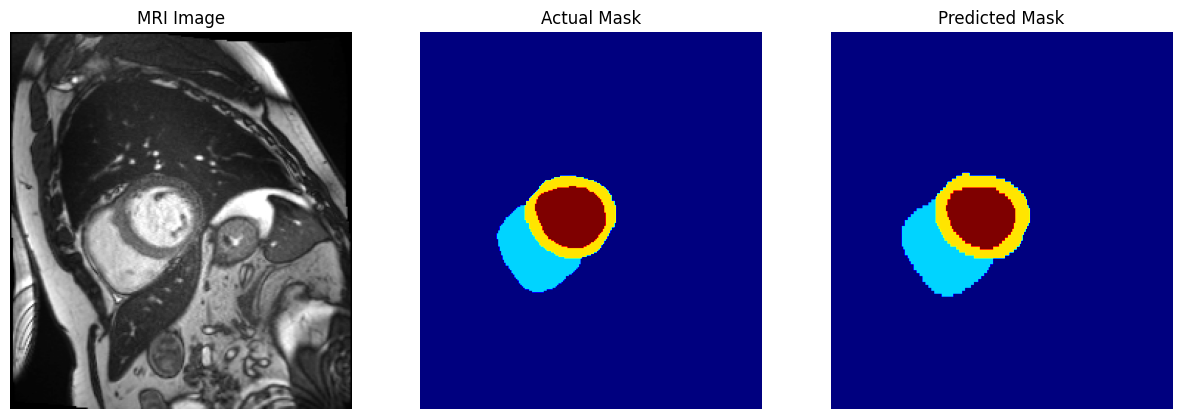

In [ ]:
visualize_result(model, test_data_loader, device)

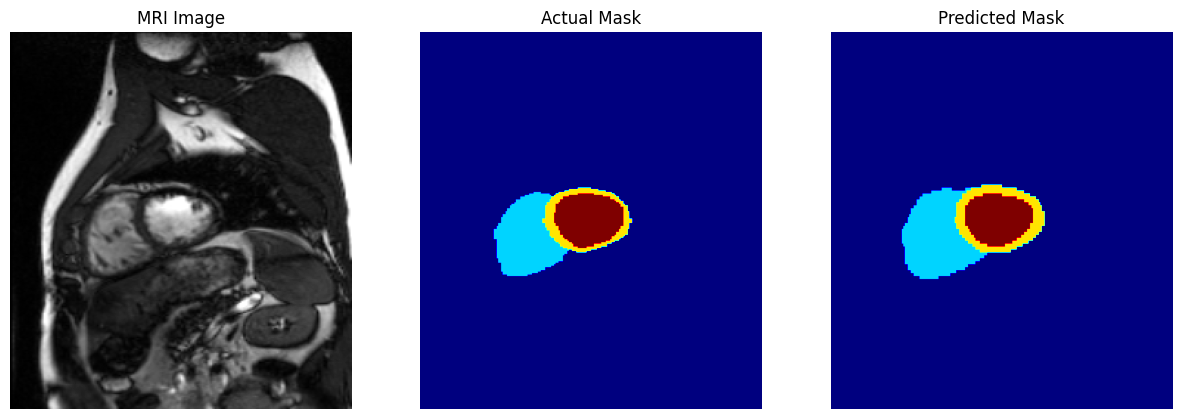

In [ ]:
visualize_result(model, test_data_loader, device)

**Categorical dice scores**

In [ ]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_data_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Convert logits to predicted class labels
        preds = torch.argmax(outputs, dim=1)  # Shape: [batch_size, H, W]

        # Resize predictions to match ground truth
        if preds.shape[1:] != masks.shape[1:]:
            masks = masks.squeeze(1)
            preds = F.interpolate(
                preds.unsqueeze(1).float(),  # Add channel dimension
                size=masks.shape[1:],        # Match masks' spatial dimensions
                mode='nearest'               # Nearest neighbor for class labels
            ).squeeze(1).long()              # Remove channel dimension

        # Compute Dice score for this batch
        batch_dice = dice_score(preds, masks, num_classes=4)  # Replace '4' with the actual number of classes
        dice_scores.append(batch_dice)

# Average Dice scores across all batches
average_dice_score = torch.stack(dice_scores).mean(dim=0)

# Print each class's Dice score
for i, score in enumerate(average_dice_score):
    print(f"Class {i} Dice Score: {score:.4f}")

Class 0 Dice Score: 0.9905
Class 1 Dice Score: 0.5717
Class 2 Dice Score: 0.6843
Class 3 Dice Score: 0.8422


# Visualize both models predictions

- Model 1: no weighted cross entropy, no image transformation
- Model 2: weighted cross entropy, transformations applied to images and masks

**Clearly visualizations coming from the second model are closer to the actual, despite both models having close accuracy and dice metrics**

<ipython-input-107-26ab84f01b42>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


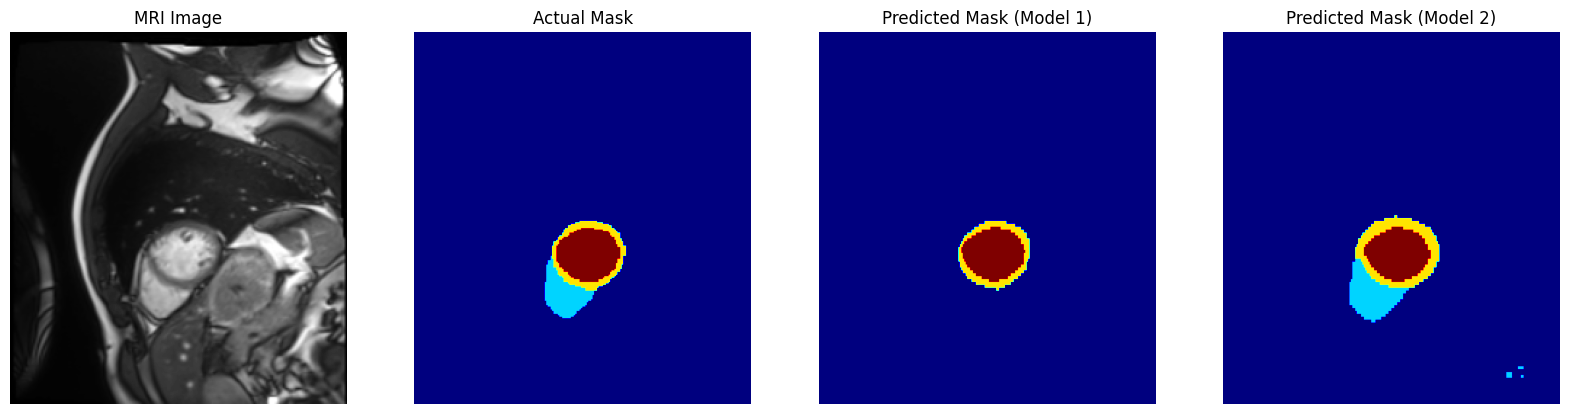

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to load model from checkpoint
def load_model(checkpoint_path, model, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Visualization function for two models
def visualize_comparison(model1, model2, test_data_loader, device):
    model1.eval()
    model2.eval()
    with torch.no_grad():
        for step, (images, labels) in enumerate(test_data_loader):
            images, labels = images.to(device), labels.to(device).squeeze(1)

            # Forward pass through first model
            outputs1 = model1(images)
            outputs1_resized = F.interpolate(outputs1, size=labels.shape[1:], mode='bilinear', align_corners=True)
            preds1 = torch.argmax(outputs1_resized, dim=1)  # Predictions from model 1

            # Forward pass through second model
            outputs2 = model2(images)
            outputs2_resized = F.interpolate(outputs2, size=labels.shape[1:], mode='bilinear', align_corners=True)
            preds2 = torch.argmax(outputs2_resized, dim=1)  # Predictions from model 2

            # Convert tensors to numpy arrays for plotting
            image = images[0].cpu().numpy()  # MRI image (single-channel)
            actual_mask = labels[0].cpu().numpy()  # Ground truth mask
            predicted_mask1 = preds1[0].cpu().numpy()  # Predicted mask from model 1
            predicted_mask2 = preds2[0].cpu().numpy()  # Predicted mask from model 2

            # Plotting the results
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))

            # Plot the original MRI image
            axs[0].imshow(image[0], cmap='gray')  # Assuming a single-channel MRI image
            axs[0].set_title("MRI Image")
            axs[0].axis('off')

            # Plot the actual mask
            axs[1].imshow(actual_mask, cmap='jet')
            axs[1].set_title("Actual Mask")
            axs[1].axis('off')

            # Plot the predicted mask from model 1
            axs[2].imshow(predicted_mask1, cmap='jet')
            axs[2].set_title("Predicted Mask (Model 1)")
            axs[2].axis('off')

            # Plot the predicted mask from model 2
            axs[3].imshow(predicted_mask2, cmap='jet')
            axs[3].set_title("Predicted Mask (Model 2)")
            axs[3].axis('off')

            plt.show()
            break  # Show just one example for simplicity

# Paths to the saved models
checkpoint_path1 = "checkpoint_no_w_transf.pth"  # Path to the first model
checkpoint_path2 = "test.pth"  # Path to the second model

# Assuming `model1` and `model2` are instances of the same architecture
model1 = U_Net(in_channels=1, out_channels=4)  # Replace with your model class
model2 = U_Net(in_channels=1, out_channels=4)  # Replace with your model class

# Load the models
model1 = load_model(checkpoint_path1, model1, device)
model2 = load_model(checkpoint_path2, model2, device)

# Visualize the comparison
visualize_comparison(model1, model2, test_data_loader, device)